# Sentiment Analysis: VADER Approach
This notebook explores a lexicon-based sentiment analysis approach using the VADER model.

### Importing and Initializing

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize logging
logging.basicConfig(level=logging.INFO)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

### Define Sentiment Labeling Function

In [17]:
def sentiment_label(compound_score, positive_threshold=0.05, negative_threshold=-0.05):
    # Assign sentiment label based on VADER compound score.
    if compound_score >= positive_threshold:
        return 'positive'
    elif compound_score <= negative_threshold:
        return 'negative'
    else:
        return 'neutral'

### Perform Sentiment Analysis

In [18]:
def vader_analysis(text):
    # Return VADER compound score and sentiment label.
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    label = sentiment_label(compound_score)
    return pd.Series([compound_score, label], index=['vader_score', 'vader_label'])

### Visualization Functions

In [19]:
def visualize_sentiment_distribution(df):
    # Bar plot showing the distribution of sentiment labels.
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sentiment_counts = df['vader_label'].value_counts()
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment Label")
    plt.ylabel("Count")
    plt.show()

def visualize_compound_score_distribution(df):
    # Histogram showing the distribution of compound sentiment scores.
    plt.figure(figsize=(10, 6))
    sns.histplot(df['vader_score'], bins=30, kde=True)
    plt.title("Compound Score Distribution")
    plt.xlabel("VADER Compound Score")
    plt.ylabel("Frequency")
    plt.show()

### Main Function

In [20]:
def main(input_file, origin_file):
    # Perform sentiment analysis on raw reviews
    try:
        # Read CSV (no headers)
        df = pd.read_csv(input_file, header=None)
        df_origin = pd.read_csv(origin_file)
        # Use the first column (raw reviews) as the text for analysis
        text_column = df.iloc[:, 0]
        #print(text_column.head())  # Print first few rows for verification

    except FileNotFoundError:
        raise FileNotFoundError(f"Input file '{input_file}' not found.")
    except pd.errors.EmptyDataError:
        raise ValueError(f"Input file '{input_file}' is empty or invalid.")

    logging.info("Performing sentiment analysis...")
    tqdm.pandas(desc="Apply Vader Analysis")
    # Apply VADER analysis to raw review texts
    results = text_column.progress_apply(vader_analysis)
    df[['vader_score', 'vader_label']] = results

    # Save results to CSV
    output_file = 'Data/VADER/reviews_VADER.csv'
    df.to_csv(output_file, index=False, header=False)
    logging.info(f"Sentiment analysis complete. Results saved to {output_file}.")

    # Call visualization functions
    logging.info("Creating sentiment distribution visualization...")
    visualize_sentiment_distribution(df)
    visualize_compound_score_distribution(df)

    df_predicted = df.iloc[:, [3]]
    new_df_origin = df_origin.iloc[:, [1]]

    conf_matrix = confusion_matrix(new_df_origin, df_predicted)
    print("Confusion Matrix:")
    
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Positive", "Neutral", "Negative"])
    disp.plot()

    # Classification Report
    report = classification_report(new_df_origin, df_predicted)
    print("Classification Report:")
    print(report)

### Execute Main Function

INFO:root:Performing sentiment analysis...
Apply Vader Analysis: 100%|██████████| 61594/61594 [00:15<00:00, 3899.27it/s]
INFO:root:Sentiment analysis complete. Results saved to Data/VADER/reviews_VADER.csv.
INFO:root:Creating sentiment distribution visualization...


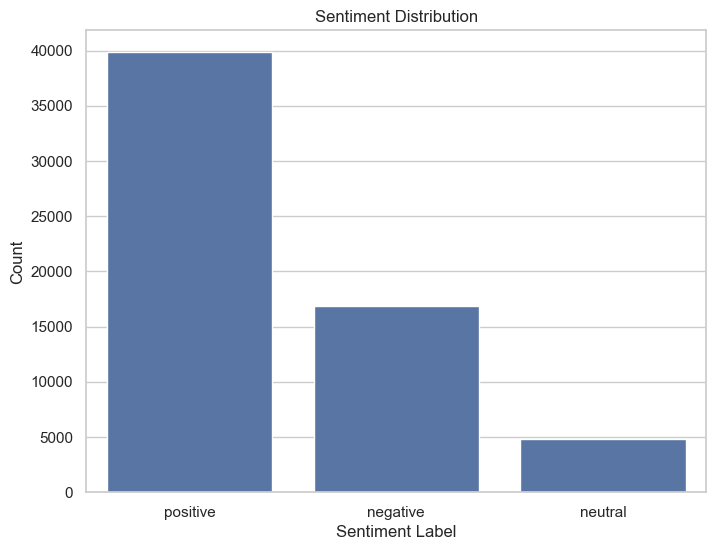

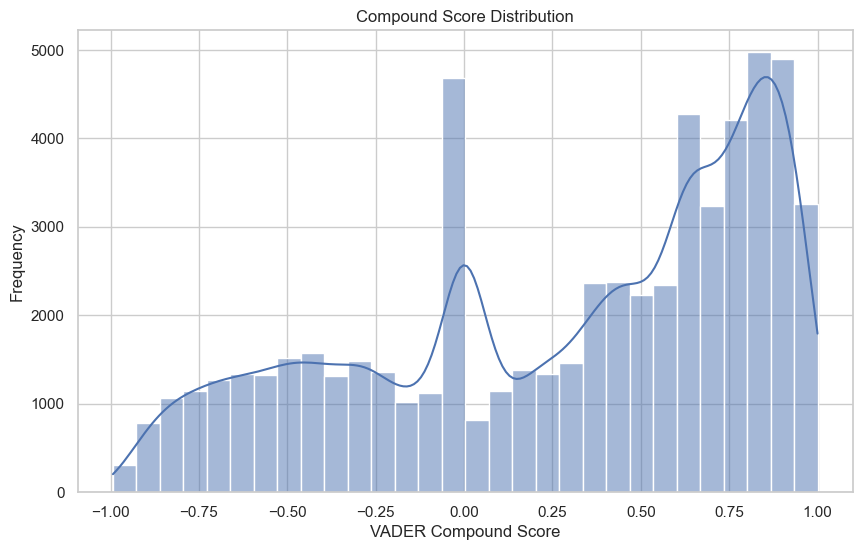

Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.50      0.60     24771
     neutral       0.14      0.10      0.11      6886
    positive       0.66      0.88      0.75     29937

    accuracy                           0.64     61594
   macro avg       0.51      0.49      0.49     61594
weighted avg       0.63      0.64      0.62     61594



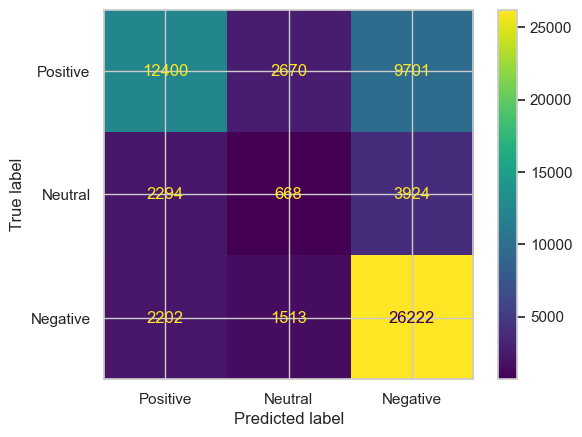

In [21]:
main("Data/spotify_reviews_full.csv", "Data/reviews_label_origin.csv")